<a href="https://colab.research.google.com/github/tanyagupta1/Machine-Learning/blob/main/BTP/HOPE_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/BTP Data/Tanya_HOPE_Annotated/"
folders = ["Test_Annotated/","Train_Annotated/","Validation_Annotated/"]

import pandas as pd
import os

df = pd.DataFrame()
shapes = []
conversation_id=0
for i in range(3):
  for filename in os.listdir(path+folders[i]):
      cpath = path+folders[i]
      f = os.path.join(cpath, filename)
      if os.path.isfile(f):
          temp = pd.read_csv(f)
          temp['conv_id']=conversation_id
          shapes.append(temp.shape[0])
          df = pd.concat([df,temp[0:-3]])
          conversation_id+=1


df.shape

(11537, 8)

In [ ]:
df

,Utterance,Sub topic,ID,Type,Dialogue_Act,Emotion,conv_id,Unnamed: 3
0,You okay now kind of taking a look at some of ...,routine,2_0,T,id,NaN,0,NaN
1,I like my job because I felt like I was helpin...,story,2_1,P,id,2.0,0,NaN
2,So you remember accomplishing things at that j...,routine,2_2,T,crq,NaN,0,NaN
3,"Yeah, I feel like, you know, doing my job, I g...",story,2_3,P,cd,NaN,0,NaN
4,You kept people safe. And you had a lot of sat...,routine,2_4,T,yq,NaN,0,NaN
...,...,...,...,...,...,...,...,...
13,I don't know.,inactive,214_13,P,on,NaN,190,NaN
14,I really need you to tell me that you're going...,routine,214_14,T,crq,NaN,190,NaN
15,I'll go look at all those things. And I'll fin...,routine,214_15,P,cd,NaN,190,NaN
16,"Okay, well, I think you really need to think a...",routine,214_16,T,od,NaN,190,NaN


In [ ]:
emotion_df = pd.read_csv("/content/drive/MyDrive/BTP Data/Tanya_HOPE_Annotated/hope_emotion.csv")

In [ ]:
emotion_df.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
emotion_df

,Utterance,conv_id,body_len,primary_emotion,secondary_emotion,speaker
0,You okay now kind of taking a look at some of ...,0,142,approval,sadness,T
1,I like my job because I felt like I was helpin...,0,98,joy,realization,P
2,So you remember accomplishing things at that j...,0,17,neutral,neutral,T
3,"Yeah, I feel like, you know, doing my job, I g...",0,76,approval,fear,P
4,You kept people safe. And you had a lot of sat...,0,22,curiosity,approval,T
...,...,...,...,...,...,...
11532,I don't know.,190,3,confusion,confusion,P
11533,I really need you to tell me that you're going...,190,17,curiosity,curiosity,T
11534,I'll go look at all those things. And I'll fin...,190,25,optimism,optimism,P
11535,"Okay, well, I think you really need to think a...",190,24,approval,approval,T


In [ ]:
len(emotion_df)

11537

In [ ]:
emotion_df['speaker']=df['Type'].values

In [ ]:
emotion_df.to_csv('hope_emotion_type.csv')

In [ ]:
utts = df.drop(columns=['Sub topic', 'ID', 'Type', 'Dialogue_Act', "Emotion",'Unnamed: 3'], axis=1)
len(utts)

11537

In [ ]:
utts['body_len']=utts['Utterance'].str.split().str.len()

In [ ]:
grouped_len = utts.groupby(['conv_id'])['body_len'].sum()
total_len =0
for i in grouped_len:
  total_len+=i
total_len/191

1329.2670157068062

In [ ]:
!pip install transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

In [ ]:
def emotion_label( text):
  sentences= str(text).split('.')
  emot={}
  emot['neutral']=0;
  global emotion
  for s in sentences:
    f=s.strip()
    if(len(f)==0):
      continue
    try:
      tmp_emp=emotion(f)
    except:
      print('skip')
      continue
    # print(tmp_emp ,' : ',f)
    if(tmp_emp[0]['label'] in emot.keys()):
      emot[tmp_emp[0]['label']]+=tmp_emp[0]['score']
    else:
      emot[tmp_emp[0]['label']]=tmp_emp[0]['score']
  if(len(emot.keys())>3):
    my_keys =  sorted(emot, key=emot.get, reverse=True)[:3]
  else:
    my_keys = sorted(emot, key=emot.get, reverse=True)
  if(len(my_keys)>1):
      try:
        my_keys.remove('neutral')
      except:
        pass
  print(my_keys[0:2])
  return my_keys[0:2]
def primary_emo(emocol):
  return emocol[0]
def secondary_emo(emocol):
  return emocol[-1]

In [ ]:
utts['emotion'] = utts.apply(lambda x: emotion_label(x.Utterance), axis=1)
utts['primary_emotion'] = utts['emotion'].apply(primary_emo)
utts['secondary_emotion'] = utts['emotion'].apply(secondary_emo)
utts = utts.drop(columns = 'emotion')

Streaming output truncated to the last 5000 lines.
['curiosity']
['neutral']
['approval']
['sadness']
['neutral']
['approval', 'optimism']
['curiosity', 'approval']
['approval']
['neutral']
['approval', 'surprise']
['approval']
['approval', 'admiration']
['curiosity']
['neutral']
['admiration', 'curiosity']
['neutral']
['curiosity']
['admiration', 'pride']
['approval']
['approval', 'realization']
['approval', 'disapproval']
['approval', 'admiration']
['neutral']
['realization', 'caring']
['curiosity', 'approval']
['approval', 'disappointment']
['curiosity', 'realization']
['approval', 'joy']
['curiosity', 'approval']
['approval', 'fear']
['confusion']
['approval']
['approval']
['approval']
['curiosity', 'surprise']
['confusion', 'approval']
['neutral']
['neutral']
['approval']
['approval', 'excitement']
['curiosity']
['optimism', 'realization']
['neutral']
['approval', 'amusement']
['gratitude']
['realization']
['realization', 'joy']
['approval', 'curiosity']
['neutral']
['curiosity']


In [ ]:
utts

,Utterance,conv_id,body_len,primary_emotion,secondary_emotion
0,You okay now kind of taking a look at some of ...,0,142,approval,sadness
1,I like my job because I felt like I was helpin...,0,98,joy,realization
2,So you remember accomplishing things at that j...,0,17,neutral,neutral
3,"Yeah, I feel like, you know, doing my job, I g...",0,76,approval,fear
4,You kept people safe. And you had a lot of sat...,0,22,curiosity,approval
...,...,...,...,...,...
13,I don't know.,190,3,confusion,confusion
14,I really need you to tell me that you're going...,190,17,curiosity,curiosity
15,I'll go look at all those things. And I'll fin...,190,25,optimism,optimism
16,"Okay, well, I think you really need to think a...",190,24,approval,approval


In [ ]:
utts.to_csv('hope_emotion.csv')

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [ ]:
number = utts.groupby(['conv_id'])['body_len'].sum()

In [ ]:
import re
utts['Utterance'] = \
utts['Utterance'].map(lambda x: re.sub('[,\.!?]', '', x))
utts['Utterance'] = \
utts['Utterance'].map(lambda x: x.lower())
utts.head()

,Utterance
0,you okay now kind of taking a look at some of ...
1,i like my job because i felt like i was helpin...
2,so you remember accomplishing things at that j...
3,yeah i feel like you know doing my job i got t...
4,you kept people safe and you had a lot of sati...


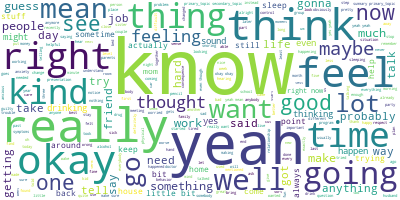

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(utts['Utterance'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'yeah', 'think', 'right', 'really', 'well'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = utts.Utterance.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['okay', 'kind', 'taking', 'look', 'thinking', 'situation', 'point', 'view', 'okay', 'things', 'kind', 'stand', 'hearing', 'talk', 'happening', 'feelings', 'appreciate', 'painful', 'would', 'say', 'reader', 'step', 'back', 'try', 'look', 'thoughts', 'see', 'helpful', 'although', 'know']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 4), (16, 1), (17, 3), (18, 1), (19, 2), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"okay" + 0.031*"would" + 0.030*"like" + 0.016*"primary_topic" + '
  '0.014*"little" + 0.014*"going" + 0.012*"getting" + 0.012*"eyes" + '
  '0.012*"describe" + 0.012*"grounding"'),
 (1,
  '0.030*"know" + 0.030*"good" + 0.026*"secondary_topic" + 0.025*"like" + '
  '0.018*"okay" + 0.017*"sense" + 0.017*"sounds" + 0.017*"relationships" + '
  '0.016*"vulnerable" + 0.016*"guys"'),
 (2,
  '0.034*"okay" + 0.027*"something" + 0.026*"like" + 0.024*"see" + '
  '0.018*"need" + 0.018*"know" + 0.017*"lot" + 0.014*"one" + 0.013*"got" + '
  '0.011*"good"'),
 (3,
  '0.033*"know" + 0.031*"got" + 0.024*"like" + 0.023*"might" + 0.022*"go" + '
  '0.021*"home" + 0.021*"summary" + 0.019*"mean" + 0.018*"time" + 0.017*"get"'),
 (4,
  '0.042*"know" + 0.033*"drive" + 0.026*"things" + 0.020*"probably" + '
  '0.019*"like" + 0.016*"home" + 0.015*"test" + 0.014*"much" + 0.014*"kind" + '
  '0.013*"could"'),
 (5,
  '0.070*"okay" + 0.022*"like" + 0.018*"better" + 0.016*"feel" + 0.015*"mean" '
  '+ 0.014*"

In [ ]:
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimviz
import pickle 

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimviz.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')
LDAvis_prepared

     |████████████████████████████████| 1.7 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c9d70f6a8257297e590470376ea6ac64c0cb26d3e4cc1ef3287ea3c53dc5436d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.017346  0.065737       1        1  18.476029
3     -0.089960  0.030591       2        1  11.494705
5      0.106640  0.052915       3        1  11.192851
8      0.053941 -0.027056       4        1  10.305298
2      0.058206 -0.191143       5        1   9.832132
1     -0.036347  0.030975       6        1   8.606852
9      0.127775  0.080732       7        1   7.845695
4     -0.147107  0.023704       8        1   7.653436
0     -0.034829 -0.040688       9        1   7.508476
7     -0.055664 -0.025766      10        1   7.084526, topic_info=                 Term        Freq       Total Category  logprob  loglift
20               okay  582.000000  582.000000  Default  30.0000  30.0000
1361             true   60.000000   60.000000  Default  29.0000  29.0000
845             drive   64.000000   64.000000  Default  28.0000  28.0000
53                got  132.000000  132.000000  Default  27.0000  27.0000
162   secondary_topic   61.000000   61.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
74                get    8.650623  180.849141  Topic10  -5.0103  -0.3928
15               kind    7.019532  158.976062  Topic10  -5.2192  -0.4728
119              mean    5.224600  176.232999  Topic10  -5.5145  -0.8712
38               time    4.826033  139.024313  Topic10  -5.5939  -0.7134
73               feel    4.158053  185.008730  Topic10  -5.7428  -1.1481

[581 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
224       1  0.669087  able
224       2  0.027879  able
224       3  0.027879  able
224       4  0.139393  able
224       5  0.027879  able
...     ...       ...   ...
374       6  0.290413   yes
374       7  0.041488   yes
374       8  0.020744   yes
374       9  0.082975   yes
369       8  0.476522   yet

[1480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 6, 9, 3, 2, 10, 5, 1, 8])